In [87]:
import numpy as np
import pandas as pd

from os import listdir
from numpy import fft as fft
from matplotlib import pyplot as plt
from scipy.stats import linregress
from uncertainties import ufloat

In [5]:
ls

main.ipynb  msd/


In [79]:
files = sorted(listdir('./msd'), key=lambda x: x.split('.')[-2])
files

['msd.T1.55.rho0.1.log',
 'msd.T1.55.rho0.2.log',
 'msd.T1.55.rho0.3.log',
 'msd.T1.55.rho0.4.log',
 'msd.T1.55.rho0.5.log',
 'msd.T1.55.rho0.6.log',
 'msd.T1.55.rho0.7.log',
 'msd.T1.55.rho0.8.log']

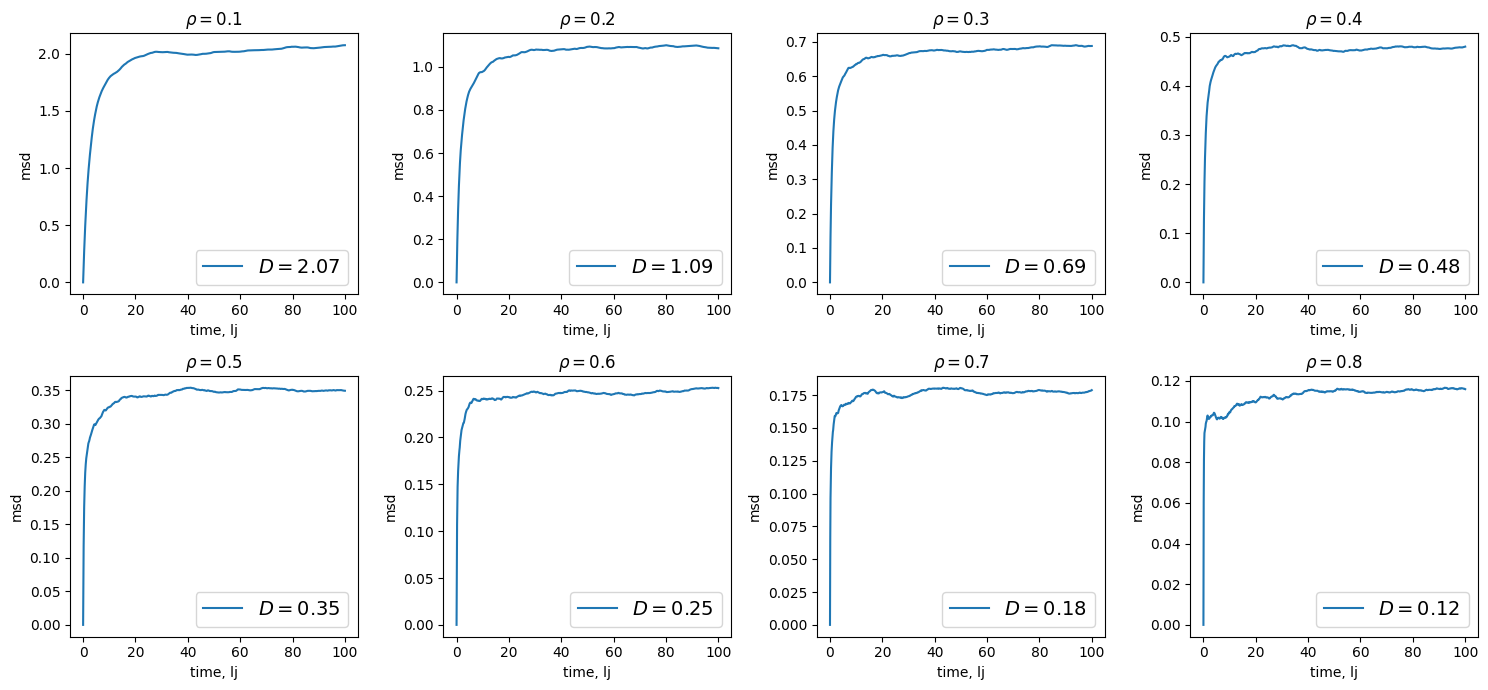

In [80]:
dfs = []
rhos = np.array([.1, .2, .3, .4, .5, .6, .7, .8])
for file in files:
    dfs.append(pd.read_csv('./msd/' + file, sep=' ', skipfooter=1, skiprows=1, names=['time', 'msd', 'D'], engine='python'))

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7))
Ds = []
for i, rho in enumerate(rhos):
    ax = axs[i // 4 ,i % 4]
    ax.set_title(f'$\\rho = {rhos[i]}$')    
    ax.plot(dfs[i]['time'], dfs[i]['D'], label=f"$D = {dfs[i]['D'].to_numpy()[-1]:.2f}$")
    ax.legend(fontsize=14)
    ax.set_xlabel('time, lj')
    ax.set_ylabel('msd')
    Ds.append(dfs[i]['D'].to_numpy()[-1])

plt.tight_layout()


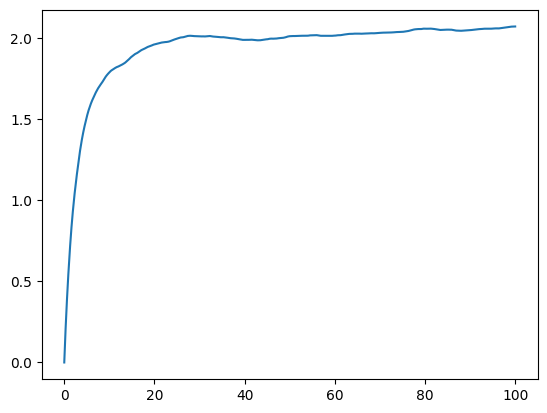

In [20]:
plt.plot(df['time'], df['D'])

In [ ]:
stress = np.genfromtxt("./shear/log.shear.T1.55.rho0.8.txt", delimiter = ' ', skip_header = True)
stress
time, pxy, pxz, pyz = stress[:,0], stress[:,1], stress[:,2], stress[:,3]



def acf(data, npts = None):
    """
    Computes time autocorrelation function of a real-valued array `data`.
    """
    
    n = len(data)
    if npts is None:
        npts = n
    npts = min(npts, n)
    dataf = fft.rfft(np.append(data, np.zeros(n)))
    acf = fft.irfft(np.conj(dataf) * dataf)[0:npts]
    for i in range(npts):
        acf[i] /= n - i
    
    return acf[0:npts]

In [73]:
files = sorted(listdir('./shear'), key=lambda x: x.split('.')[-2])
files

['log.shear.T1.55.rho0.1.txt',
 'log.shear.T1.55.rho0.2.txt',
 'log.shear.T1.55.rho0.3.txt',
 'log.shear.T1.55.rho0.4.txt',
 'log.shear.T1.55.rho0.5.txt',
 'log.shear.T1.55.rho0.6.txt',
 'log.shear.T1.55.rho0.7.txt',
 'log.shear.T1.55.rho0.8.txt']

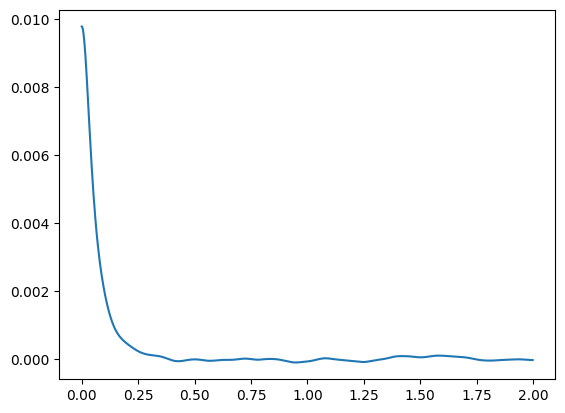

In [68]:
plt.plot(time[0:1000], acf(pxy, 1000))

In [69]:
def integrate(ydata, xdata = None):
    """
    Computes running integral of `ydata` using `xdata` as abscissae.
    """
    
    n = len(ydata)
    if xdata is None:
        xdata = range(n)
    
    integ = np.zeros(n)
    for i in range(1,n):
        integ[i] = integ[i-1] + (ydata[i-1] + ydata[i]) / 2 * (xdata[i] - xdata[i-1])
    
    return integ

In [70]:
intxy, intxz, intyz = integrate(acf(pxy, 1000), time), integrate(acf(pxz, 1000), time), integrate(acf(pyz, 1000), time)

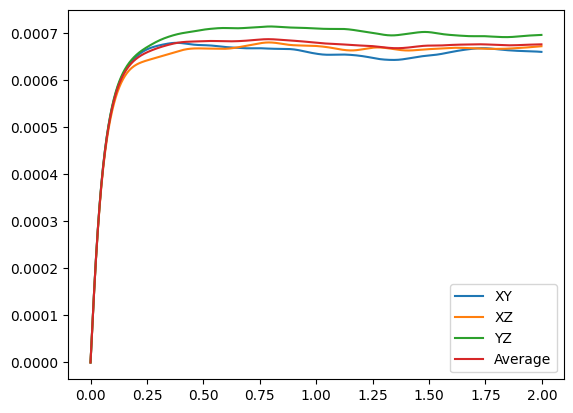

In [71]:
fig = plt.figure()
plotint = fig.add_subplot(111)
plotint.plot(time[0:1000], intxy, label="XY")
plotint.plot(time[0:1000], intxz, label="XZ")
plotint.plot(time[0:1000], intyz, label="YZ")
plotint.plot(time[0:1000], (intxy + intxz + intyz) / 3, label="Average")

plt.legend()

plt.show()

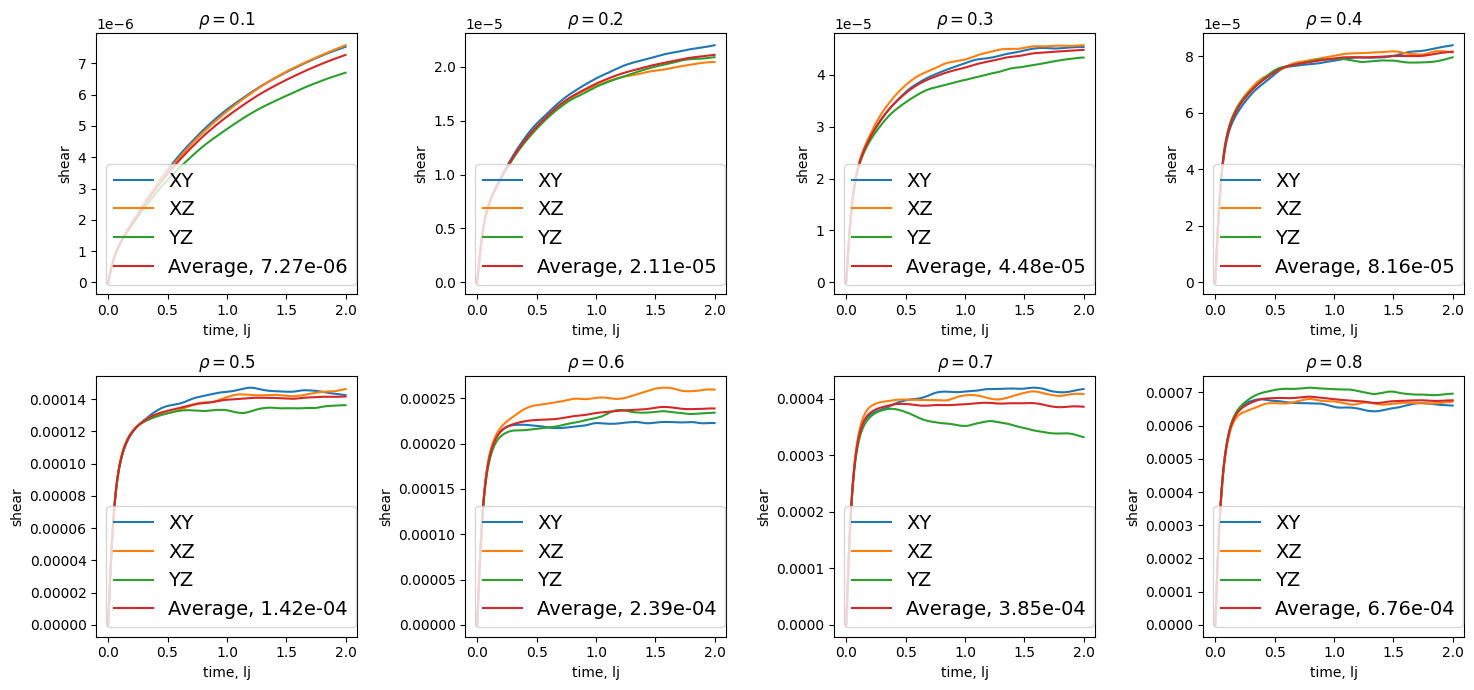

In [78]:
dfs2 = []
rhos = np.array([.1, .2, .3, .4, .5, .6, .7, .8])
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7))
etas = []
for i, file in enumerate(files):
    stress = np.genfromtxt("./shear/" + file, delimiter = ' ', skip_header = True)
    stress
    time, pxy, pxz, pyz = stress[:,0], stress[:,1], stress[:,2], stress[:,3]
    intxy, intxz, intyz = integrate(acf(pxy, 1000), time), integrate(acf(pxz, 1000), time), integrate(acf(pyz, 1000), time)
    


    ax = axs[i // 4 ,i % 4]
    ax.set_title(f'$\\rho = {rhos[i]}$')    

    ax.plot(time[0:1000], intxy, label="XY")
    ax.plot(time[0:1000], intxz, label="XZ")
    ax.plot(time[0:1000], intyz, label="YZ")
    ax.plot(time[0:1000], (intxy + intxz + intyz) / 3, label=f"Average, {((intxy + intxz + intyz) / 3)[-1]:.2e}")

    ax.legend(fontsize=14)
    ax.set_xlabel('time, lj')
    ax.set_ylabel('shear')
    etas.append(((intxy + intxz + intyz) / 3)[-1])

plt.tight_layout()


In [81]:
Ds = np.array(Ds)
etas = np.array(etas)

$$\dfrac{1}{D} = \dfrac{6 \pi \eta R}{kT}$$

$$\text{slope} = \dfrac{6 \pi R}{kT}$$

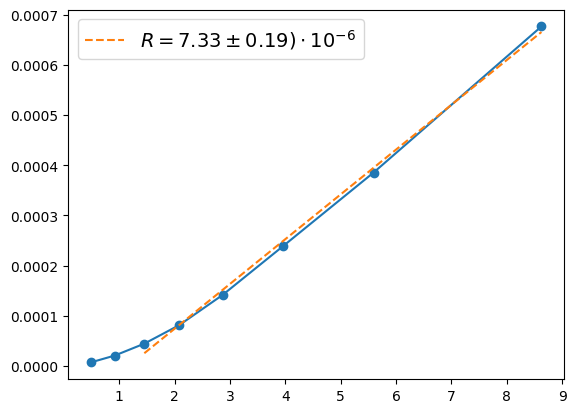

In [99]:

res = linregress(1 / Ds[2:], etas[2:])
R = ufloat(res.slope, res.stderr) * 1.55 / (6 * np.pi)

plt.plot(1/Ds, etas, marker='o')
plt.plot(1 / Ds[2:], 1 / Ds[2:] * res.slope + res.intercept, linestyle='--',
         label=f"$R = {R.nominal_value * 1e6:.2f} \pm {R.std_dev * 1e6:.2f}) \cdot 10 ^{{-6}}$")
plt.legend(fontsize=14);